#### Improvements:
1. Contents page


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer # ported to sklearn from fancyimpute
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from category_encoders import CatBoostEncoder
from tpot import TPOTClassifier
from espressomaker import Espresso
import xgboost as xgb
from hyperopt import hp, fmin, tpe
import lightgbm as lgb
from catboost import CatBoostClassifier

%config InlineBackend.figure_format = 'retina'

In [246]:
df = pd.read_csv('train.csv')

In [247]:
df_test = pd.read_csv('test.csv')

In [248]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,exceeds50K
0,30,?,147215,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States,0
1,60,Private,173960,Bachelors,13,Divorced,Prof-specialty,Not-in-family,Female,0,0,42,United-States,0
2,52,?,105428,Some-college,10,Married-civ-spouse,?,Husband,Male,0,0,12,United-States,0
3,37,Private,112497,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,60,United-States,0
4,63,Private,137843,Some-college,10,Married-civ-spouse,Sales,Husband,Male,7298,0,48,United-States,1


In [249]:
df.shape

(24421, 14)

In [250]:
# We can see that we have 2 main types of data: int64 and object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24421 non-null  int64 
 1   workclass       24421 non-null  object
 2   fnlwgt          24421 non-null  int64 
 3   education       24421 non-null  object
 4   education-num   24421 non-null  int64 
 5   marital-status  24421 non-null  object
 6   occupation      24421 non-null  object
 7   relationship    24421 non-null  object
 8   sex             24421 non-null  object
 9   capital-gain    24421 non-null  int64 
 10  capital-loss    24421 non-null  int64 
 11  hours-per-week  24421 non-null  int64 
 12  native-country  24421 non-null  object
 13  exceeds50K      24421 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 2.6+ MB


In [251]:
df.rename(columns={"exceeds50K":"class"}, inplace=True)

In [252]:
df.describe() # this is applicable to numeric columns
# We can see that our features are of very different scales.

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class
count,24421.000000,2.442100e+04,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000
mean,38.587036,1.888204e+05,10.096515,1116.029974,86.547643,40.511609,0.239998
std,13.677055,1.046917e+05,2.574488,7646.590185,399.096945,12.367526,0.427091
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175830e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778240e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.365860e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3900.000000,99.000000,1.000000


#### Exploration of numeric features.

In [253]:
numerical = df.select_dtypes(include = ['int'])
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             24421 non-null  int64
 1   fnlwgt          24421 non-null  int64
 2   education-num   24421 non-null  int64
 3   capital-gain    24421 non-null  int64
 4   capital-loss    24421 non-null  int64
 5   hours-per-week  24421 non-null  int64
 6   class           24421 non-null  int64
dtypes: int64(7)
memory usage: 1.3 MB


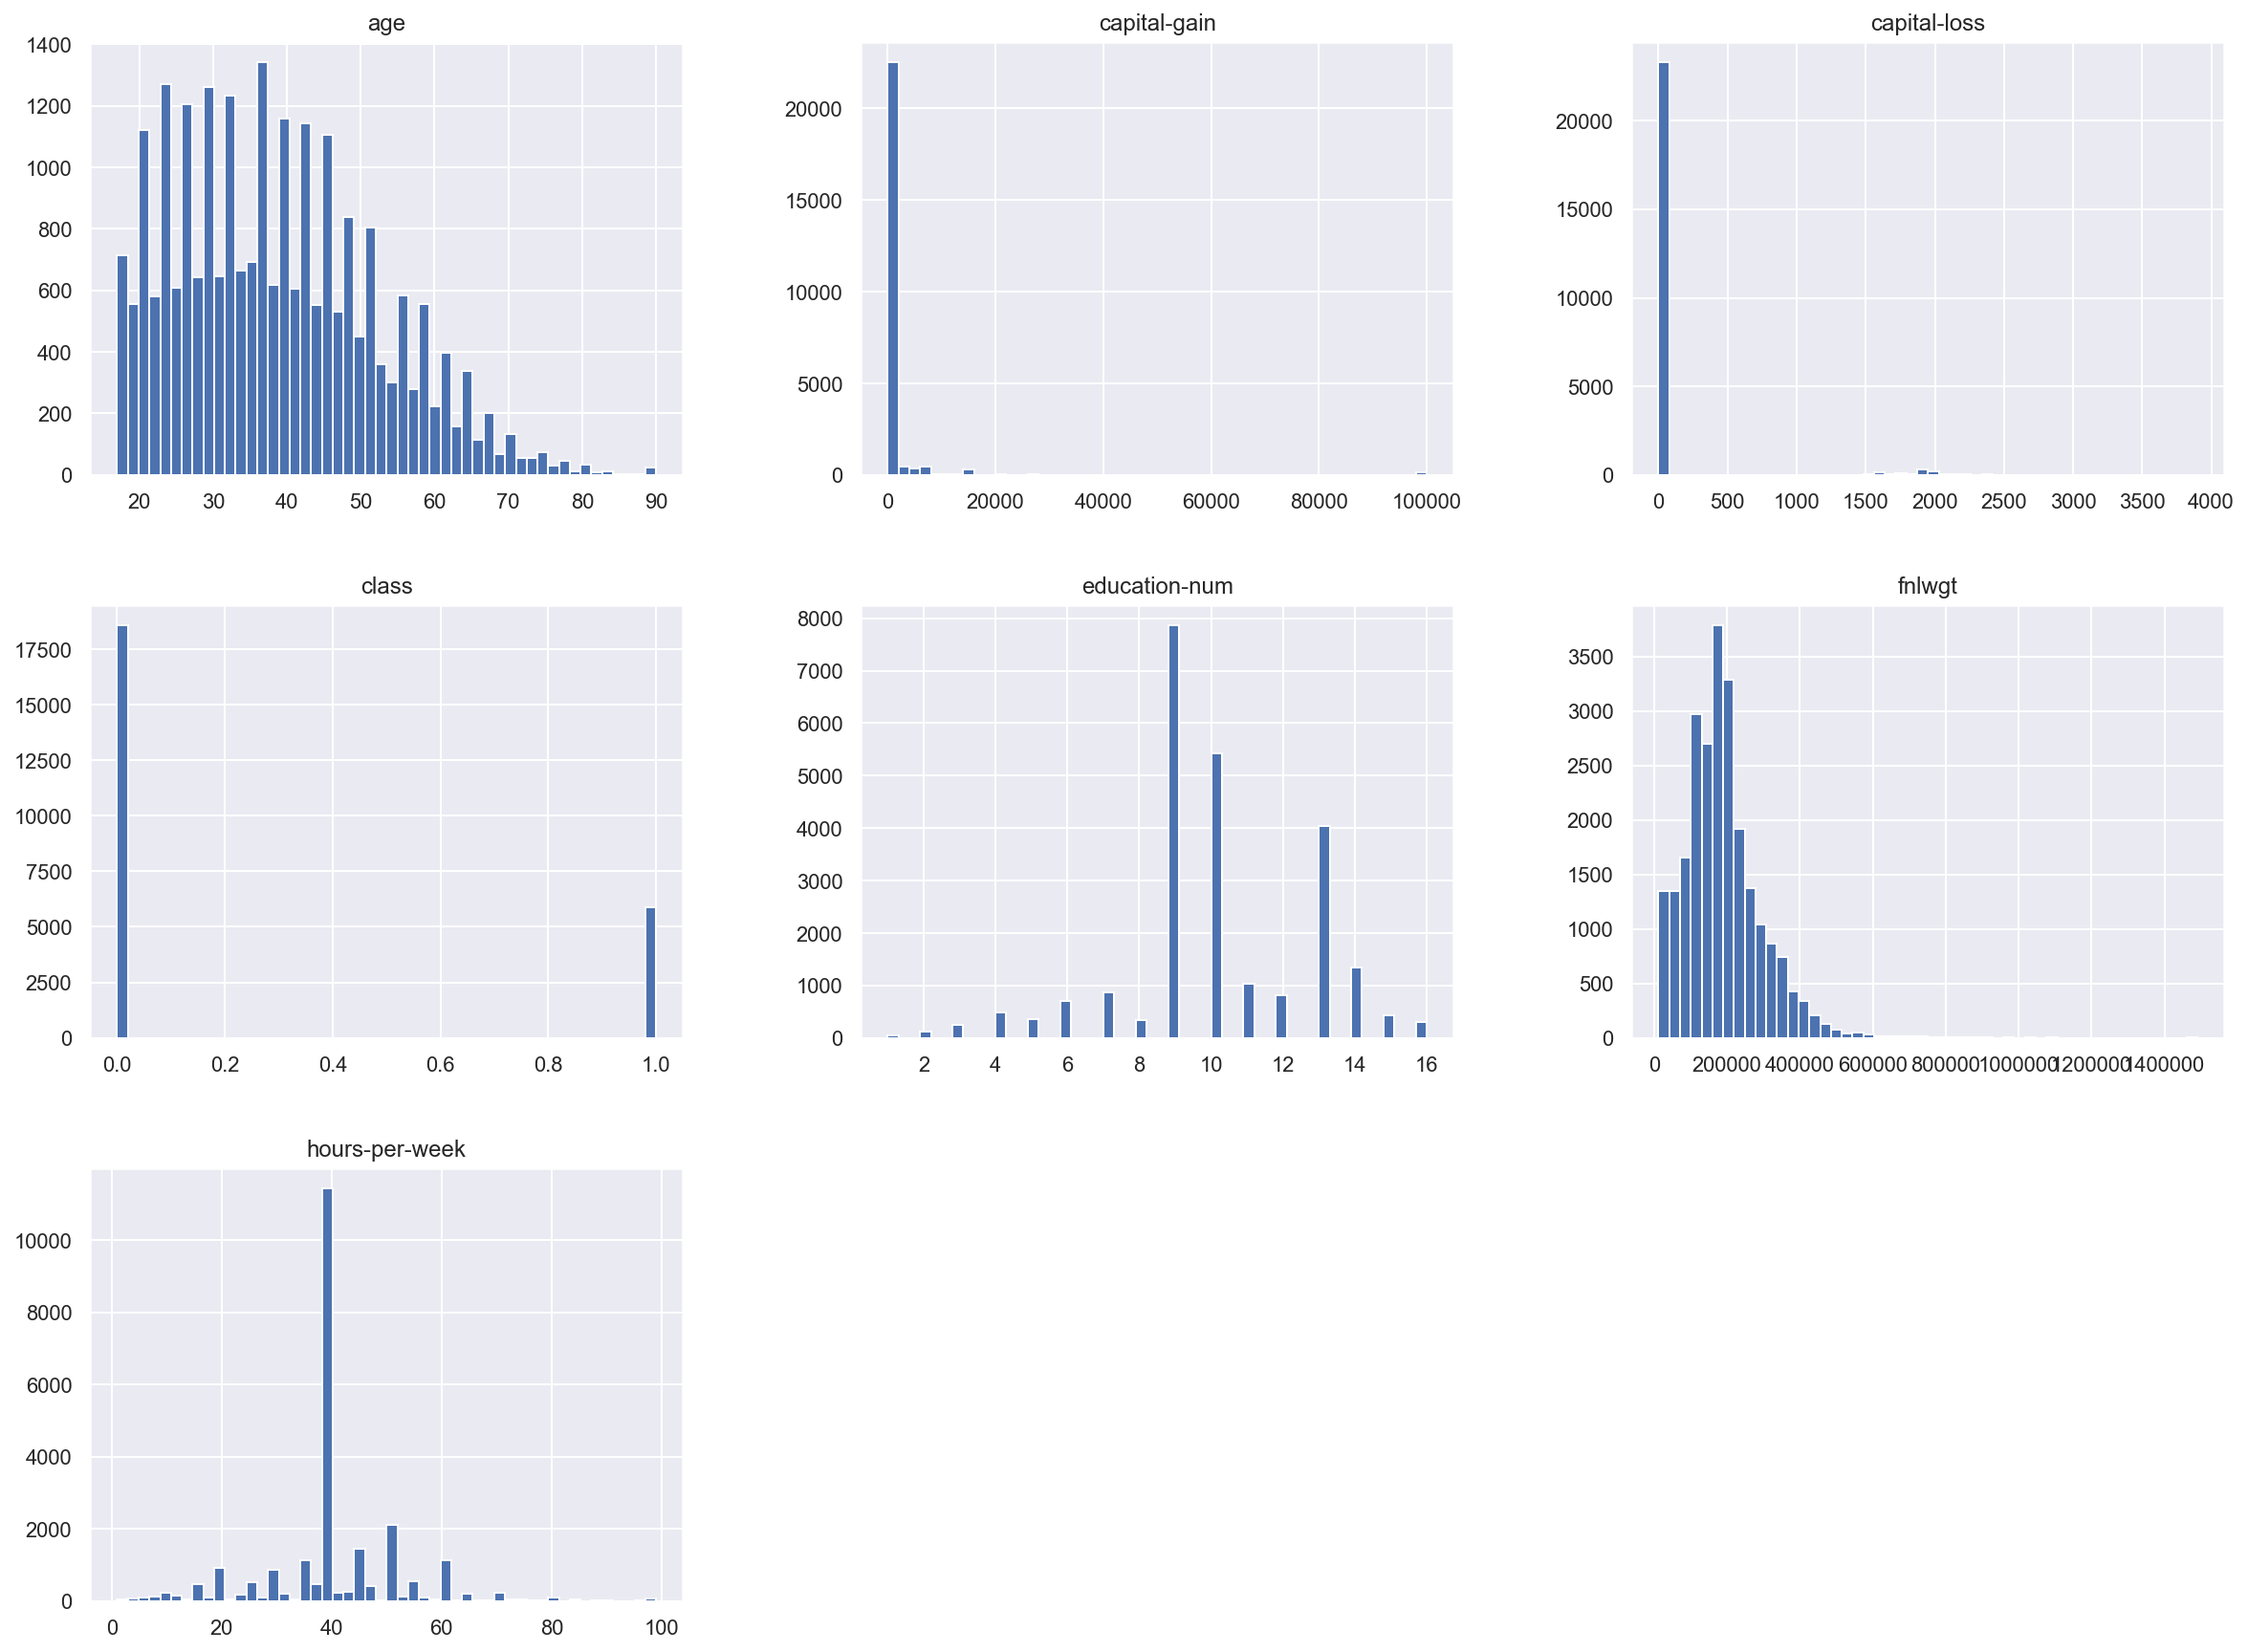

In [254]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

Some observations for above numerical plots:
1. Age should be cut into different discrete categories for better visualization? scatter plot with age and education number.
2. Capital-gain and capital-loss: Values are very skewed, we just care whether there is a loss or gain or stayput?
3. Class is imbalanced, optimizing for AUC does not sound like a good idea.
4. Education-num and hours-per-week looks roughly normally distributed.
5. Hours-per-week looks like there are some outliers. 
6. fnlwgt looks right-tail heavy, may want to consider doing some log transformations.

In [255]:
numerical_cols = list(set(numerical.columns) - set(['class']))

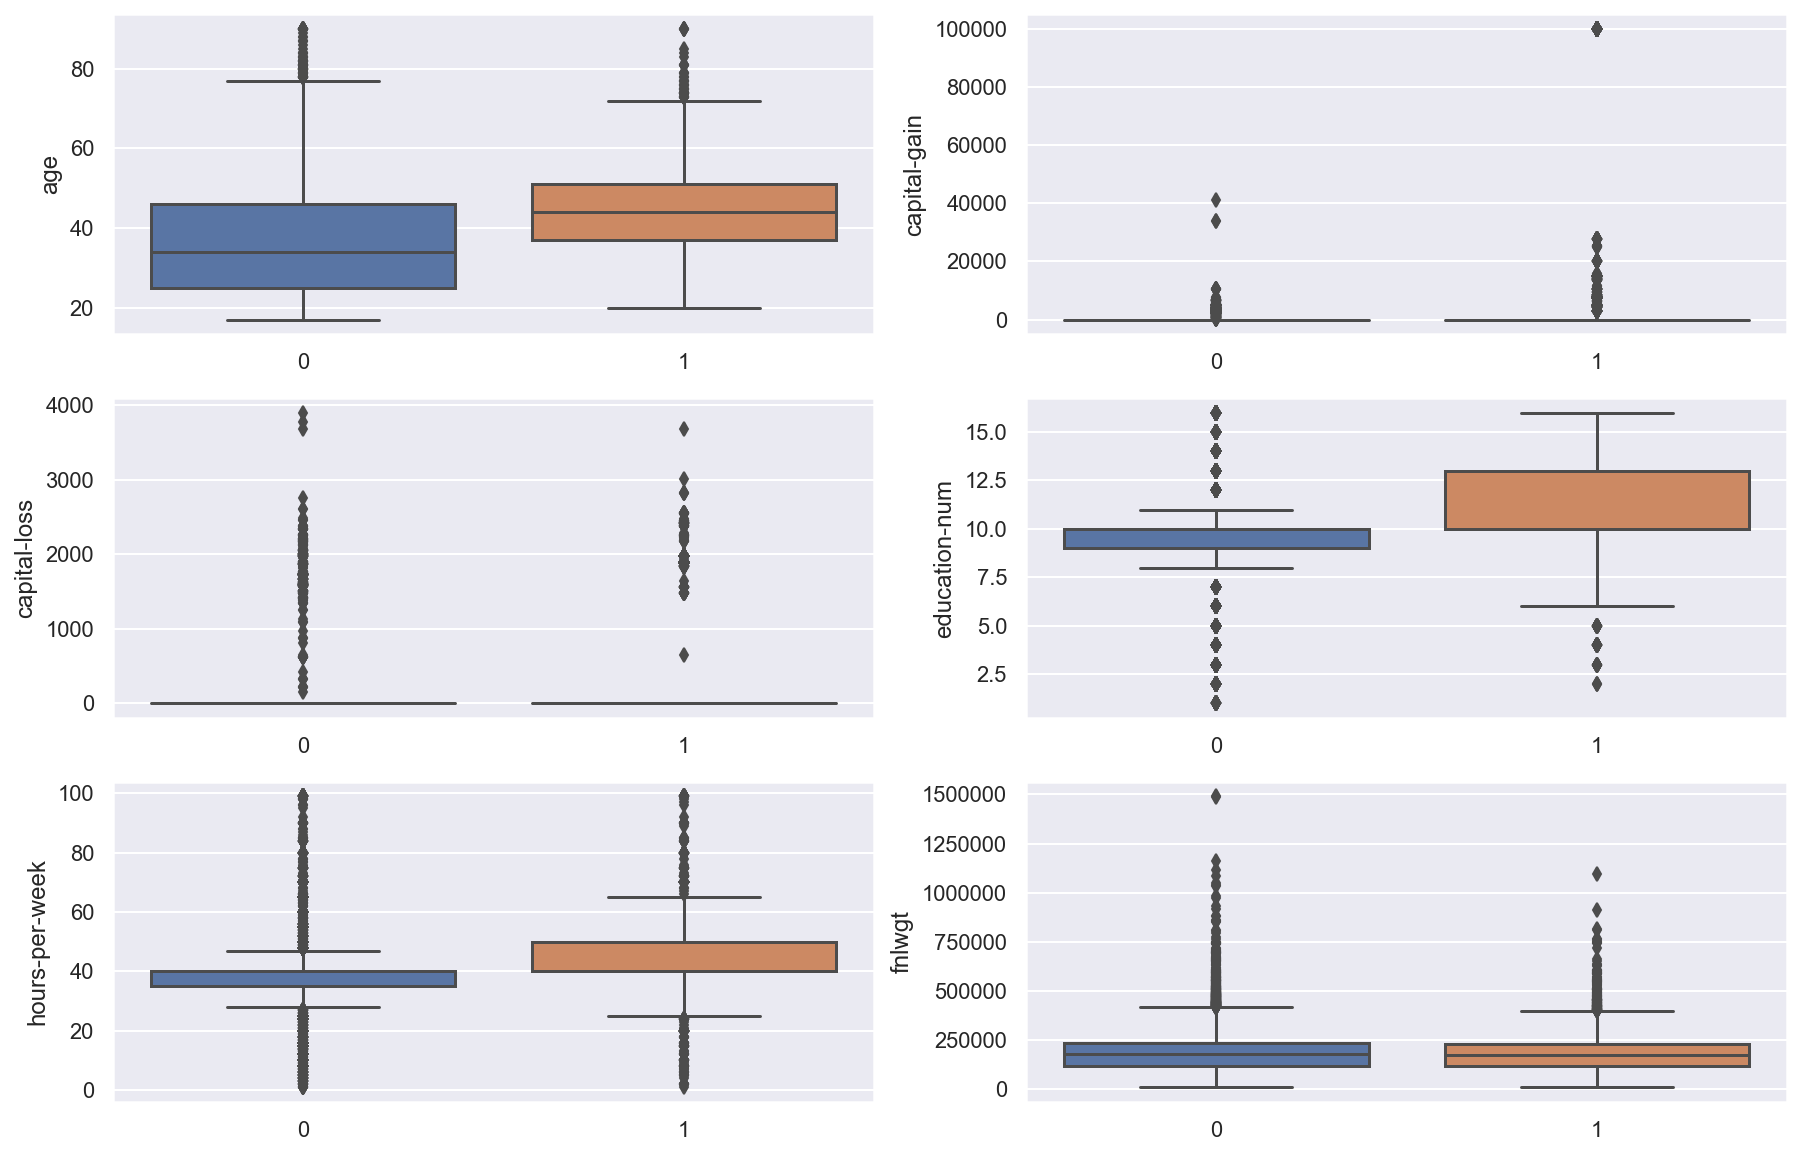

In [256]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,10))
for idx, feat in enumerate(numerical_cols):
    ax = axes[int(idx/2), idx%2]
    sns.boxplot(x='class',y=feat, data=df,ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
plt.show()

It is clear that we have 3 important numerical features which have discriminative power for classification: **education-num, hours-per-week and age.** What does this imply, when we do the train-test split, we should make sure our splits also have a fair distribution over these categories. 

We can further confirm this using Point Biserial Correlation.

In [257]:
numerical_cols += ['class']

In [258]:
# # https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
# from scipy.stats import pointbiserialr

# numerical_features = df['hours-per-week']
# labels = df['class']

# pbc = pointbiserialr(numerical_features, labels)
# print(pbc)

df[numerical_cols].corr()

# We can consider dropping fnlwgt since it clearly has nothing to do with
# our target variable.


,age,capital-gain,capital-loss,education-num,hours-per-week,fnlwgt,class
age,1.000000,0.084777,0.050775,0.033251,0.076735,-0.079282,0.237521
capital-gain,0.084777,1.000000,-0.031652,0.127242,0.089132,-0.004108,0.226486
capital-loss,0.050775,-0.031652,1.000000,0.082065,0.052133,-0.004153,0.151032
education-num,0.033251,0.127242,0.082065,1.000000,0.143665,-0.043784,0.333001
hours-per-week,0.076735,0.089132,0.052133,0.143665,1.000000,-0.015185,0.220001
fnlwgt,-0.079282,-0.004108,-0.004153,-0.043784,-0.015185,1.000000,-0.005331
class,0.237521,0.226486,0.151032,0.333001,0.220001,-0.005331,1.000000


#### Exploration of categorical features.

In [259]:
categorical = df.select_dtypes(include = ['object'])

In [260]:
categorical.info()

# We note that education is just a discrete representation of our education-num
# feature, we should not have duplicate information, and just drop education. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       24421 non-null  object
 1   education       24421 non-null  object
 2   marital-status  24421 non-null  object
 3   occupation      24421 non-null  object
 4   relationship    24421 non-null  object
 5   sex             24421 non-null  object
 6   native-country  24421 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [261]:
categorical_cols = list(set(categorical.columns) - set(['education']))

In [262]:
for cat in categorical_cols:
    print("Number of levels in category '{0}': \b {1:2}".format(cat, df[cat].unique().size))

Number of levels in category 'workclass':   9
Number of levels in category 'relationship':   6
Number of levels in category 'occupation':  15
Number of levels in category 'native-country':  41
Number of levels in category 'sex':   2
Number of levels in category 'marital-status':   7


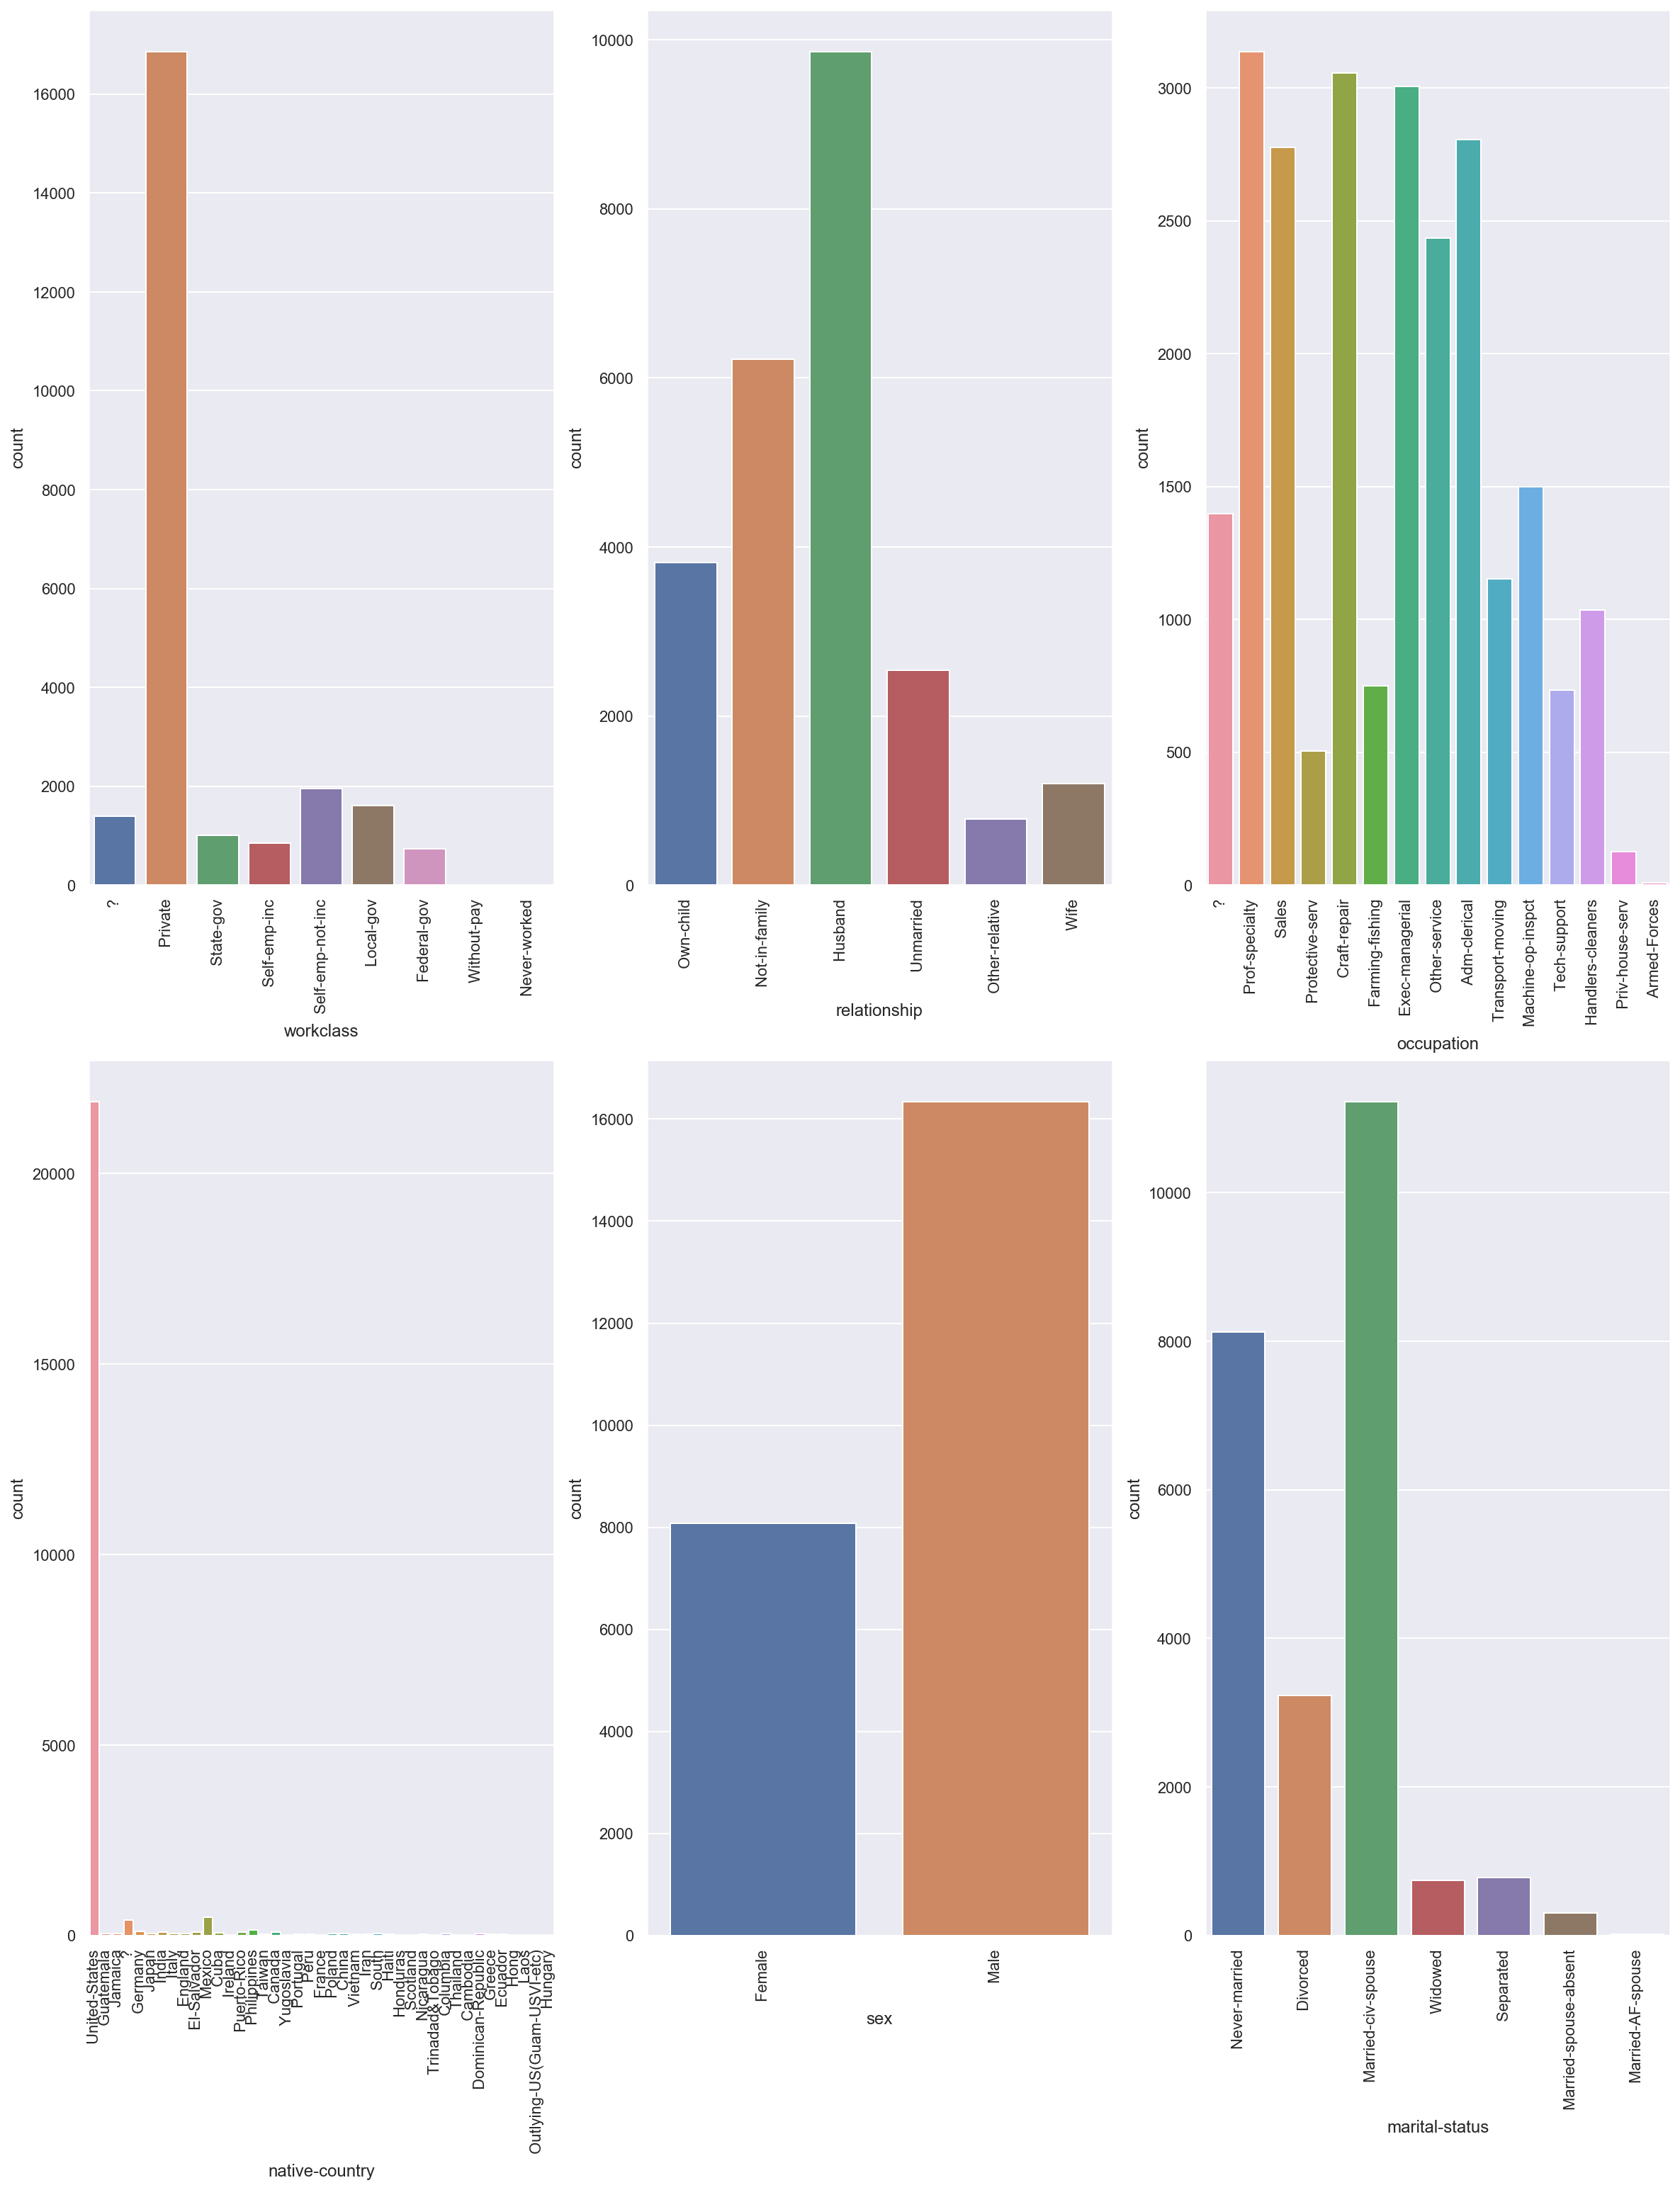

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,25))
for idx, feat in enumerate(categorical_cols):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(x=feat, data=df,ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

Some conclusions about the plot:

Notably, we see that in the native-country field, the U.S count is exceptionally skewed. For plotting purposes, given that we have too many categories for nationality, we will not plot the countplot for the nationality feature. Let us do a simple countplot for the other features.

In [264]:
categorical_cols_toplot = ['relationship', 'occupation', 'workclass',
                          'sex', 'marital-status']

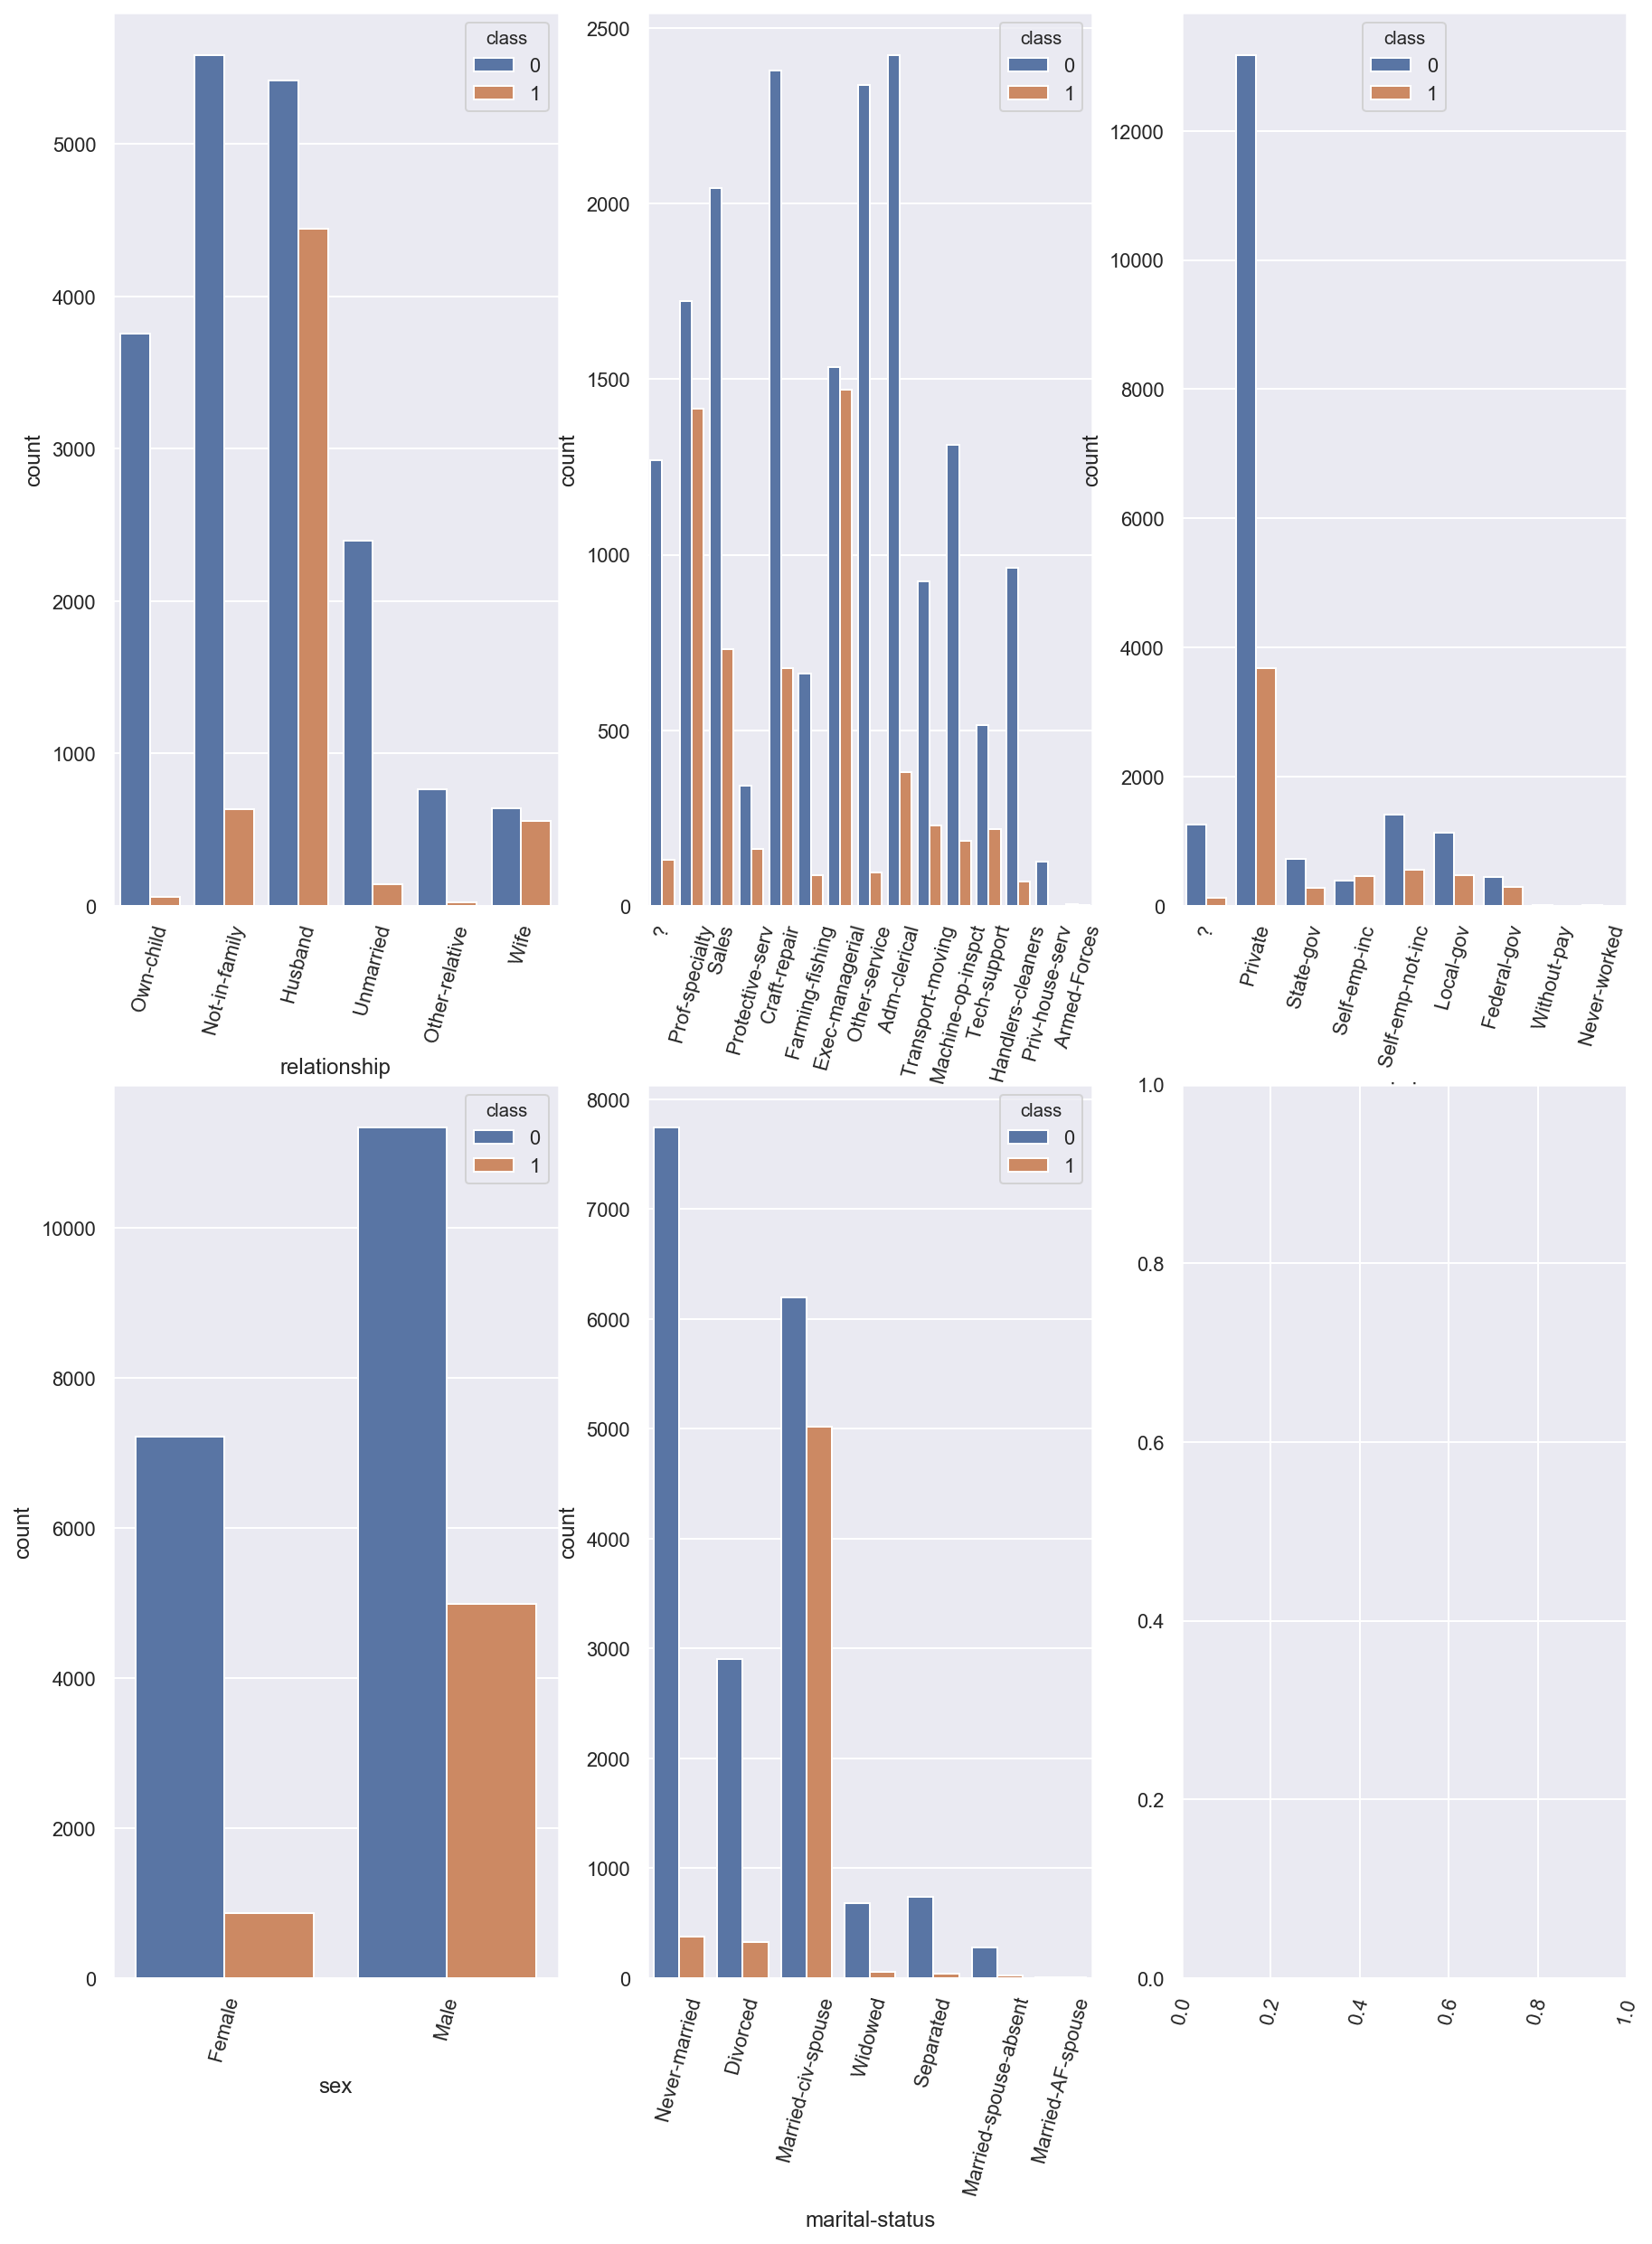

In [265]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,20))
for idx, feat in enumerate(categorical_cols_toplot):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(df[feat], hue=df['class'],ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)
plt.show()

Some interesting observations:
1. Males have a higher proportion earning > 50K.
2. The relationship variable and marital-status are painting the same picture that a large proportion of married-civ-spouse (husbands and wives) are generally earning more than 50K.
3. Generally all categorical features are influential in determining target variable.

For the nationalities, instead of plotting, we can consider doing a contigency table to understand if nationality does indeed affect our target variable. We should expect the ratios of our target variable to be about constant across the different nationalities, should nationality not be important.

We can see that countries such as Taiwan and Japan have a much higher proportion of '1' labels as compared to the other countries. It is clear that native-country does indeed influence the probability of the target variable. 

In [266]:
pd.crosstab(df['native-country'], df['class'], margins = 'index').sort_values(by = [1], ascending=False)

class,0,1,All
native-country,,,
All,18560,5861,24421
United-States,16542,5341,21883
?,300,110,410
Philippines,106,40,146
India,44,36,80
Canada,57,29,86
Germany,79,29,108
Mexico,458,24,482
England,35,23,58


#### Step 1: StratifiedShuffleSplit based on important variables.

We know from earlier EDA that we have `education-num` to be important in predicting if income >= 50K. We will consider discretizing the continuous variable into categories, so that our train-test split can be representative.

In [267]:
df['education-cat'] = pd.cut(df['education-num'], bins = [0., 5., 7., 9., 12., 17], 
                             labels = [1,2,3,4,5])


In [268]:
df['education-cat'].value_counts()

3    8194
4    7279
5    6117
2    1568
1    1263
Name: education-cat, dtype: int64

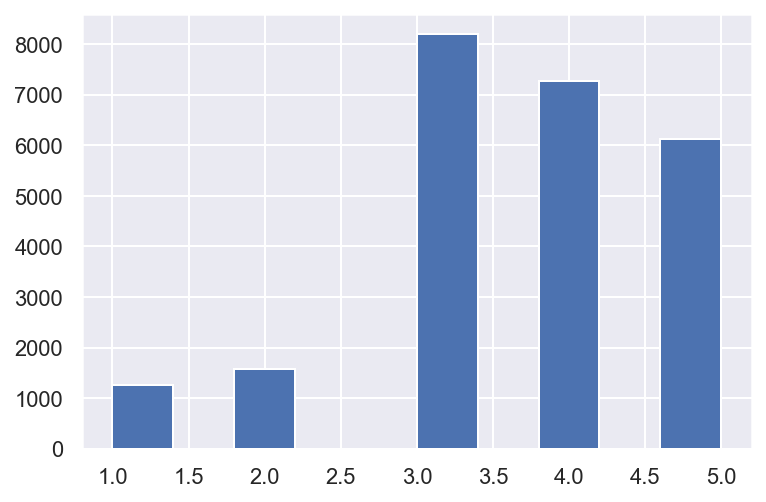

In [269]:
df['education-cat'].hist()

In [270]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["education-cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [271]:
strat_test_set['education-cat'].value_counts() / len(strat_test_set)

3    0.335517
4    0.298055
5    0.250358
2    0.064278
1    0.051791
Name: education-cat, dtype: float64

In [272]:
df['education-cat'].value_counts() / len(df)

3    0.335531
4    0.298063
5    0.250481
2    0.064207
1    0.051718
Name: education-cat, dtype: float64

In [273]:
def education_cat_proportions(data):
    return data['education-cat'].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

compare_props = pd.DataFrame({
    "Overall": education_cat_proportions(df),
    "Stratified": education_cat_proportions(strat_test_set),
    "Random": education_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [274]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.051718,0.051791,0.053634,3.704312,0.141951
2,0.064207,0.064278,0.065097,1.386455,0.111153
3,0.335531,0.335517,0.339202,1.094010,-0.004175
4,0.298063,0.298055,0.303173,1.714347,-0.002641
5,0.250481,0.250358,0.238895,-4.625725,-0.049067


In [275]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('education-cat', axis=1, inplace=True)

In [276]:
X_train = strat_train_set.copy()

In [277]:
X_val = strat_test_set.copy()

#### Step 2: Removal of outliers using statistical analysis

We will ignore `capital gain` and `capital loss` for now, as we will feature engineer those later.

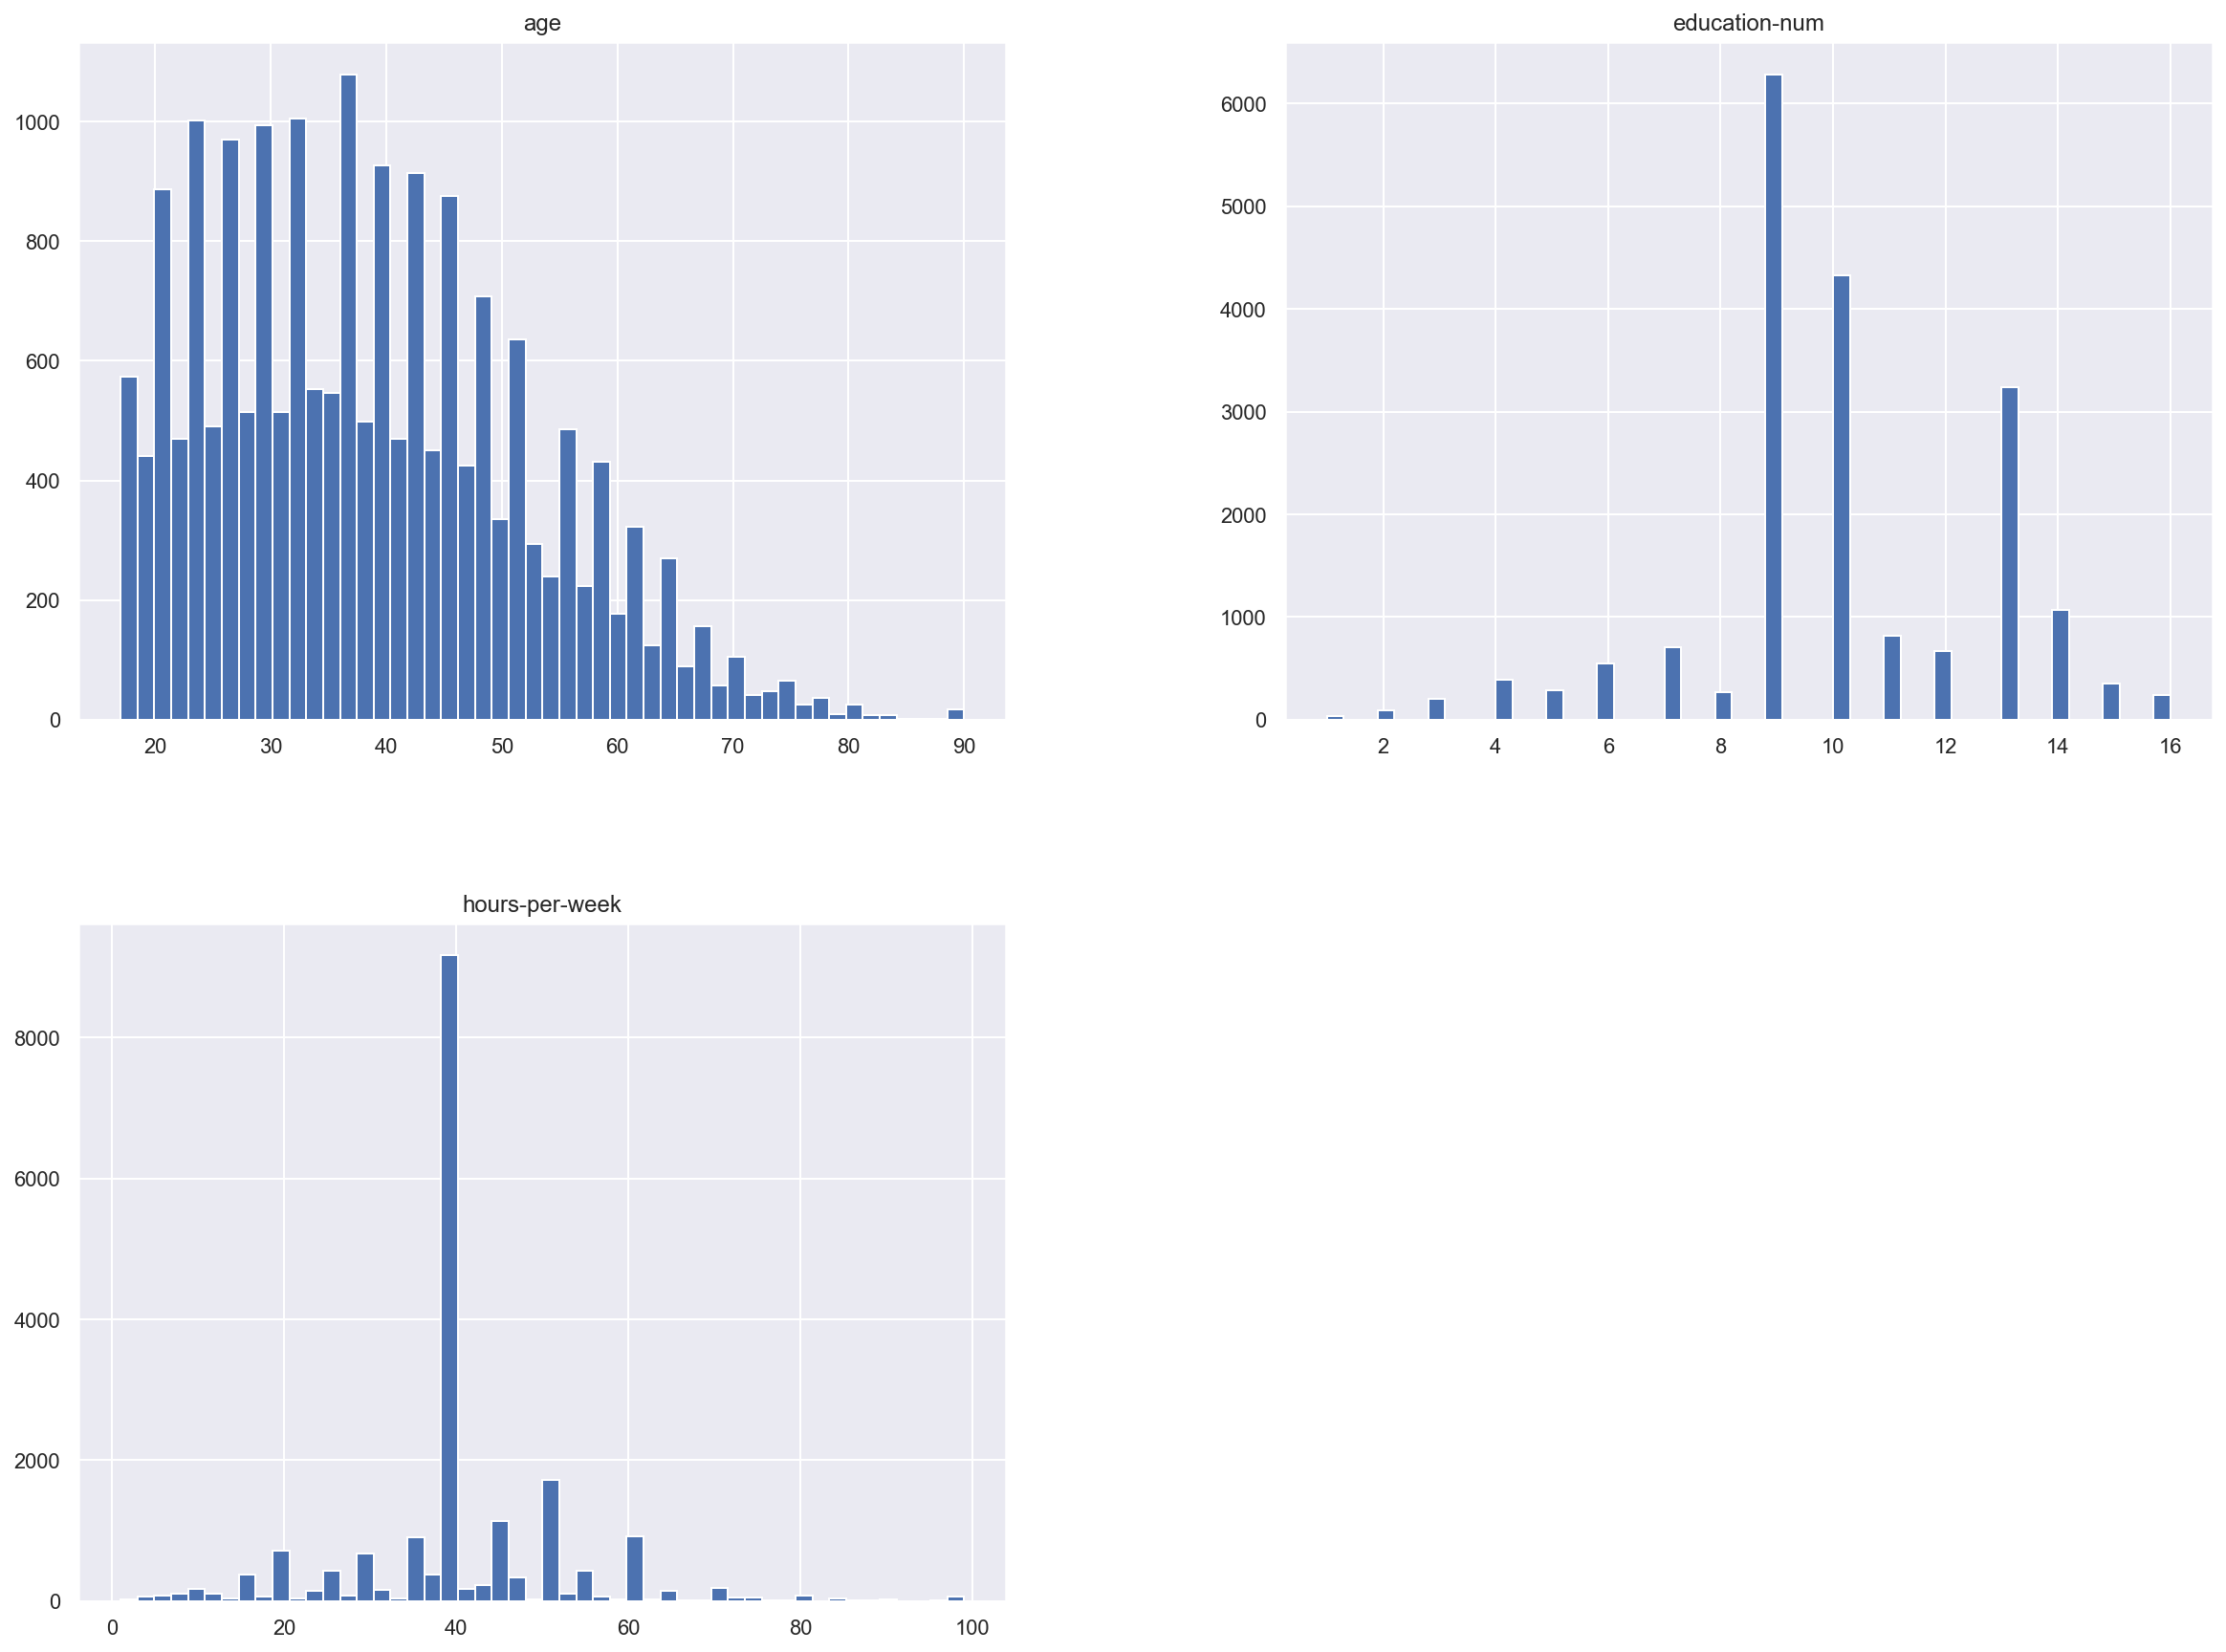

In [278]:
import matplotlib.pyplot as plt
numeric_cols_outliers = ['age', 'education-num', 'hours-per-week']
X_train[numeric_cols_outliers].hist(bins=50, figsize=(20,15))
plt.show()

In [216]:
# def remove_statistical_outliers(train_data, test_data, cols, threshold=3):
#     print(f'Current size of train_data: {train_data.shape}')
#     print(f'Current size of test_data: {test_data.shape}')
#     for col in cols:
#         train_std = train_data[col].std()
#         train_mean = train_data[col].mean()
        
#         cut_off = train_std * threshold
#         train_lower, train_upper = train_mean - cut_off, train_mean + cut_off
#         train_data = train_data[(train_data[col] < train_upper) & (train_data[col] > train_lower)]
#         test_data = test_data[(test_data[col] < train_upper) & (test_data[col] > train_lower)]
#         print('*' * 50)
#         print(f'Current size of train_data after removing outliers for {col}: {train_data.shape}')
#         print(f'Current size of test_data after removing outliers for {col}: {test_data.shape}')
#     return train_data, test_data
        

In [217]:
# X_train, X_val = remove_statistical_outliers(X_train, X_val, numeric_cols_outliers)

Current size of train_data: (19536, 14)
Current size of test_data: (4885, 14)
**************************************************
Current size of train_data after removing outliers for age: (19472, 14)
Current size of test_data after removing outliers for age: (4865, 14)
**************************************************
Current size of train_data after removing outliers for education-num: (19345, 14)
Current size of test_data after removing outliers for education-num: (4825, 14)
**************************************************
Current size of train_data after removing outliers for hours-per-week: (19090, 14)
Current size of test_data after removing outliers for hours-per-week: (4760, 14)


In [279]:
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,class
17910,46,Private,191204,Assoc-voc,11,Never-married,Exec-managerial,Own-child,Female,0,0,40,United-States,0
23682,35,Private,454843,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,United-States,1
21792,36,Self-emp-not-inc,165855,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,40,Germany,0
11950,62,Local-gov,206063,Some-college,10,Divorced,Other-service,Not-in-family,Male,0,0,45,United-States,0
1949,44,Private,215304,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,45,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,33,Private,123253,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,55,United-States,1
13944,37,Private,84306,Some-college,10,Married-civ-spouse,Other-service,Husband,Male,0,0,40,United-States,0
255,52,Private,187356,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,Male,0,0,41,United-States,0
14684,35,Private,115792,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,55,United-States,0


#### Step 3: Handling missing values and duplicated values:
We first deal with duplicated rows.

We can see 20 non-unique rows, which effectively translates to 10 duplicated rows.

In [280]:
X_train[X_train.duplicated(subset = list(set(X_train.columns) - set(['class'])), keep = False)].sort_values(by = list(X_train.columns))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,class
22391,17,Private,153021,12th,8,Never-married,Sales,Own-child,Female,0,0,20,United-States,0
22798,17,Private,153021,12th,8,Never-married,Sales,Own-child,Female,0,0,20,United-States,0
13105,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,Male,0,0,14,United-States,0
21624,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,Male,0,0,14,United-States,0
18217,23,Private,239539,HS-grad,9,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,Philippines,0
720,23,Private,239539,HS-grad,9,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,Philippines,0
1863,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,Female,0,0,40,Guatemala,0
20513,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,Female,0,0,40,Guatemala,0
22605,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,Male,0,0,40,Mexico,0
15139,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,Male,0,0,40,Mexico,0


We can proceed to drop the duplicated rows by simply doing the following:

In [281]:
X_train.drop_duplicates(subset = list(set(X_train.columns) - set(['class'])), keep='first',inplace=True)

We proceed to also clean for missing rows. Earlier on while we were doing our EDA, it was noteworthy to point out that some of the features: `native-country`, `occupation`, `workclass` had '?' to indicate they were missing. Let us take a look at some of these entries.

In [282]:
bool_mask = X_train.select_dtypes([np.object]).apply(lambda x: x.str.contains('\?'), axis = 1).any(axis = 1)

In [283]:
X_train[bool_mask] # we can see 1429 rows which have a question mark in them.

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,class
5931,43,Private,132633,Some-college,10,Married-civ-spouse,Handlers-cleaners,Wife,Female,0,0,40,?,0
23977,26,Private,147821,Bachelors,13,Never-married,Sales,Own-child,Female,0,0,45,?,0
4528,62,?,176753,HS-grad,9,Married-civ-spouse,?,Husband,Male,0,0,40,United-States,0
23153,90,?,225063,Some-college,10,Never-married,?,Own-child,Male,0,0,10,South,0
11196,38,Private,103408,Masters,14,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,40,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13624,74,?,132112,HS-grad,9,Married-civ-spouse,?,Husband,Male,0,0,48,United-States,0
1100,17,?,110998,Some-college,10,Never-married,?,Own-child,Female,0,0,40,Philippines,0
18129,65,?,195733,Some-college,10,Married-civ-spouse,?,Husband,Male,0,0,30,United-States,1
11164,20,?,210781,Some-college,10,Never-married,?,Own-child,Female,0,0,10,United-States,0


In [284]:
X_train = X_train.replace(to_replace='.*\?', value=np.nan, regex=True)
X_val = X_val.replace(to_replace='.*\?', value=np.nan, regex=True)

In [285]:
X_test = df_test.replace(to_replace='.*\?', value=np.nan, regex=True)

In [286]:
X_train.isnull().any() # We can see that we have missing values in the 3 columns as discussed.

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
class             False
dtype: bool

In [287]:
y_train = X_train['class']
y_val = X_val['class']

In [288]:
X_train.drop('class', inplace=True, axis=1)
X_val.drop('class', inplace=True, axis=1)

#### Step 4: Feature Engineering
We note that in the earlier EDA, we have discussed that we want to remove some columns: `education`, `fnlwgt`. We also should consider doing some engineering on our capital-gain and capital-loss features to be one of the three values: 1 for capital gain, -1 for capital loss, and 0 for no gain/loss.


https://brendanhasz.github.io/2019/03/04/target-encoding.html#target-encoding
https://github.com/EpistasisLab/tpot/blob/master/tutorials/MAGIC%20Gamma%20Telescope/MAGIC%20Gamma%20Telescope.ipynb
https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
https://www.kaggle.com/residentmario/encoding-categorical-data-in-sklearn

- Other encoders, CatBoost, JamesStein (not good only for normal)?
- Imputers?
- Engineer married variable, one hot encoding for 2 columns.
- ADASYN, with tree based models? not too sure if can work.


#### AttributesRemover:

In [289]:
X_train_copy = X_train.copy()

In [290]:
X_train_copy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
17910,46,Private,191204,Assoc-voc,11,Never-married,Exec-managerial,Own-child,Female,0,0,40,United-States
23682,35,Private,454843,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,United-States
21792,36,Self-emp-not-inc,165855,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,40,Germany
11950,62,Local-gov,206063,Some-college,10,Divorced,Other-service,Not-in-family,Male,0,0,45,United-States
1949,44,Private,215304,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,45,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,33,Private,123253,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,55,United-States
13944,37,Private,84306,Some-college,10,Married-civ-spouse,Other-service,Husband,Male,0,0,40,United-States
255,52,Private,187356,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,Male,0,0,41,United-States
14684,35,Private,115792,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,55,United-States


#### AttributesAdder:

In [291]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['marital-status'] = X['marital-status'].map({' Never-married': 'Single', ' Divorced': 'Single',
                              ' Married-civ-spouse': 'Married', ' Married-spouse-absent': 'Married',
                              ' Married-AF-spouse': 'Married', ' Never-married': 'Single', ' Separated': 'Single'})
        X['capital'] = X['capital-gain'] - X['capital-loss']
        def mapper(x):
            if x['capital'] != 0:
                return 1
            else:
                return 0
        
        X['capital'] = X.apply(mapper, axis=1)
        X.drop(['capital-gain', 'capital-loss', 'education'], inplace=True,axis=1)
        return X

FE = FeatureEngineer()
testt = FE.transform(X_train_copy)

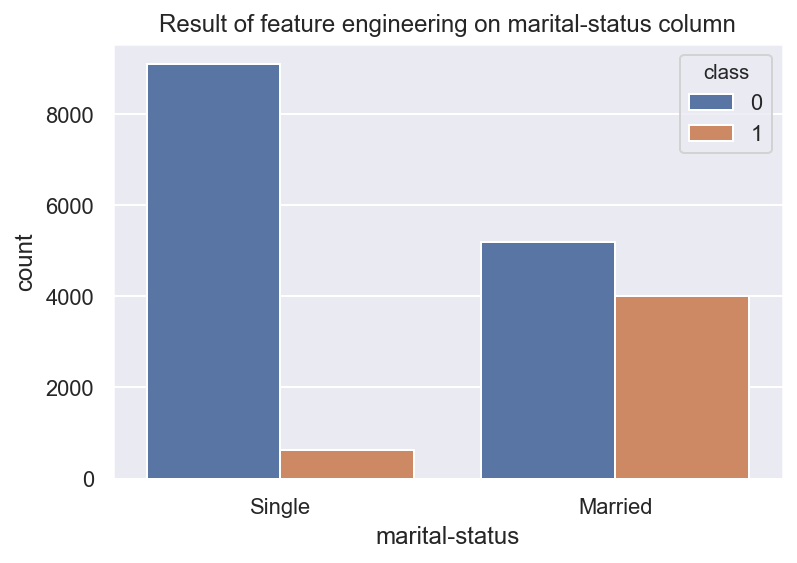

In [292]:
sns.countplot(testt['marital-status'], hue=y_train)
plt.title('Result of feature engineering on marital-status column')
plt.show() #

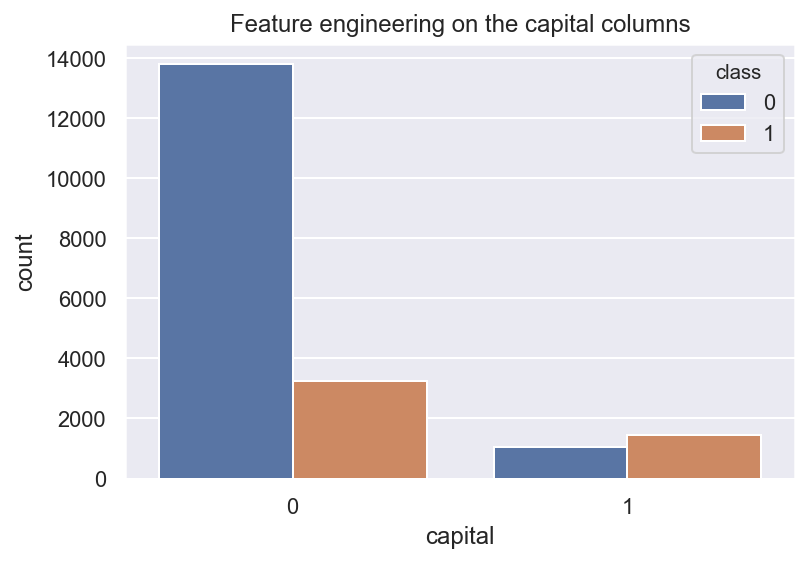

In [293]:
sns.countplot(testt['capital'], hue=y_train)
plt.title('Feature engineering on the capital columns')
plt.show()

In [294]:
class OneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = pd.get_dummies(data=X, columns=self.cols)
        return X

# oht = OneHotTransformer(['sex', 'marital-status'])
# testtt = oht.transform(testt)

#### After feature engineering, what happens?

#### Imputer and the TargetEncoders:
For imputers, we can experiment with IterativeImputers, which we can check out.
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

For categorical variable encoders, we consider using TargetEncoders:

In [295]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.
    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

### Tree-based Models and AutoML approach with processed numerical data with pipeline:
1. Feature Engineering
2. Categorical Encoding with OneHotEncoders and TargetEncoders
3. Normalisation
4. Imputation
5. ADASYN to balance class labels

In [296]:
final_cols = ['age',
            'workclass',
            'fnlwgt',
            'education-num',
            'occupation',
            'relationship',
            'hours-per-week',
            'native-country',
            'capital',
            'sex_ Female',
            'sex_ Male',
            'marital-status_Married',
            'marital-status_Single']

In [297]:
X_train_copy = X_train.copy()

In [298]:
pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('cat_onehot', OneHotTransformer(['sex', 'marital-status'])),
    ('cat_target', TargetEncoderCV()), # CatBoostEncoder?
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer()),
])

X_prepared = pipeline.fit_transform(X_train_copy, y_train)
X_val_prepared = pipeline.transform(X_val)
X_test_prepared = pipeline.transform(X_test)


#### Resampling technique to get balanced class labels.

In [299]:
X = pd.DataFrame(data=X_prepared, columns=final_cols)

In [300]:
ada = ADASYN()

In [301]:
X_train_resampled, y_train_resampled = ada.fit_sample(X, y_train)

##### TPOT

In [ ]:
with Espresso.shot(display_on = True):
    random_seeds = [21]
    winning_pipelines = []

    for seed in random_seeds:
        tpot = TPOTClassifier(cv=5, generations=20,
                              population_size=25,
                              scoring='f1',n_jobs=-1,
                              random_state=seed, verbosity=2)
        tpot.fit(X_train_resampled, y_train_resampled)
        current_pipe = tpot.fitted_pipeline_
        val_score = current_pipe.score(X_val_prepared, y_val)
        tpot.export(f'target_cv_adasyn_{val_score}.py')
#         current_pipe = tpot.fitted_pipeline_
        winning_pipelines.append(current_pipe)

        print(f'Current val score: {val_score}')
        print(f'Current pipe: {current_pipe}')

### XGBClassifier with Bayesian Hyperopt tuning

In [ ]:
with Espresso.shot(display_on = False):   
    space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0, 100),
            'subsample': hp.uniform('subsample', 0.5, 1.0)}

    def xgb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'min_child_weight': int(params['min_child_weight']),
                 'colsample_bytree': params['colsample_bytree'],
                 'reg_lambda': params['reg_lambda'],
                  'subsample': params['subsample'],
                 }
        xgb_clf = xgb.XGBClassifier(n_estimators=100, **params)
        best_score = cross_val_score(xgb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=10, n_jobs=-1, verbose=False).mean()
        loss = 1 - best_score
        return loss

    best = fmin(fn=xgb_objective,space=space, max_evals=100, rstate=np.random.RandomState(42), algo=tpe.suggest)
    print(best)

[espressomaker] Started on Fri, 08/May/2020 22:50:15 (display_on = False).
 68%|██████▊   | 68/100 [10:16<06:26, 12.06s/trial, best loss: 0.1253208346255974] 

### CatBoostClassifier with Bayesian Hyperopt Tuning

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
with Espresso.shot(display_on = False):   
    cat_space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.8),
            'bagging_temperature': hp.uniform('bagging_temperature', 0, 100),
            'l2_leaf_reg': hp.qloguniform('l2_leaf_reg', 0, 2, 1),
            }
    
    def cb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'bagging_temperature': params['bagging_temperature'],
                 'l2_leaf_reg': int(params['l2_leaf_reg']),
                 }
        cb_clf = CatBoostClassifier(n_estimators=100, **params)
        best_score = cross_val_score(cb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=5, verbose=False).mean()
        loss = 1 - best_score
        return loss

    cat_best = fmin(fn=cb_objective,space=cat_space, max_evals=50, rstate=np.random.RandomState(42), algo=tpe.suggest)
    print(cat_best)
    

### LightGBMClassifier with Bayesian Hyperopt Tuning

In [670]:
with Espresso.shot(display_on = True):   
    space = {'max_depth': hp.quniform('max_depth', 2, 12, 2),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.8),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
            'min_child_samples': hp.quniform('min_child_samples', 10, 50, 2),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0, 100),
            'subsample': hp.uniform('subsample', 0.5, 1.0)}

    def lgb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'min_child_weight': int(params['min_child_weight']),
                 'min_child_samples': int(params['min_child_samples']),
                 'colsample_bytree': params['colsample_bytree'],
                 'reg_lambda': params['reg_lambda'],
                 'subsample': params['subsample'],
                 }
        lgb_clf = lgb.LGBMClassifier(n_estimators=100, **params)
        best_score = cross_val_score(lgb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=10, n_jobs=-1).mean()
        loss = 1 - best_score
        return loss

    lgb_best = fmin(fn=lgb_objective,space=space, max_evals=500, rstate=np.random.RandomState(21), algo=tpe.suggest)
    print(lgb_best)

[espressomaker] Started on Fri, 08/May/2020 18:27:15 (display_on = False).
100%|██████████| 500/500 [00:39<00:00, 12.81trial/s, best loss: nan]

[espressomaker] Finished on Fri, 08/May/2020 18:27:54.


AllTrialsFailed: 

In [ ]:
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909
# https://gist.github.com/talperetz/6030f4e9997c249b09409dcf00e78f91
    
# Set up space dictionary with specified hyperparameters
space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),'learning_rate': hp.uniform('learning_rate', 0.001, 0.9)}

# Set up objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),'learning_rate': params['learning_rate']}
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params) 
    best_score = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=2, n_jobs=4).mean()
    loss = 1 - best_score
    return loss

# Run the algorithm
best = fmin(fn=objective,space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest)
print(best)



#### ADASYN with CatBoostEncoder

In [258]:
ada = ADASYN()

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer()),
])

ce = CatBoostEncoder()
X_target_encoded = ce.fit_transform(X_train, y_train)

X_processed = numerical_pipeline.fit_transform(X_target_encoded, y_train)

X_processed = pd.DataFrame(
                X_processed,
                columns = list(X_target_encoded.columns),
                index = X_target_encoded.index)

X_resampled, y_resampled = ada.fit_sample(X_processed, y_train)

attr_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('attribs_remover', AttributesRemover()),
])

X_prepared = attr_pipeline.fit_transform(X_resampled.values)

####### val set transformations
X_val_encoded = ce.transform(X_val)
X_val_processed = numerical_pipeline.transform(X_val_encoded)
X_val_prepared = attr_pipeline.transform(X_val_processed)

####### test set transformations
X_test_encoded = ce.transform(X_test)
X_test_processed = numerical_pipeline.transform(X_test_encoded)
X_test_prepared = attr_pipeline.transform(X_test_processed)

In [68]:
output_pred = tpot.predict(X_test_prepared)

#### TargetEncoder with KFold.


In [265]:
from datetime import datetime

In [266]:
output_df = pd.DataFrame({'id': [i+1 for i in range(len(output_pred))], 'prediction': output_pred})
output_df.to_csv('predictions_xgbc_' + datetime.now().strftime('%d%m%y') + '_all.csv', index = False)

In [ ]:
# Remember we have te.transform, and attr_pipeline.transform.

In [327]:
# Encoder -> Imputer ->  Adder -> Remover.
# Numeric Pipeline: Attribute remover, CombinedAttributesAdder.
# Categorical Pipeline: Attribute remover (education), Imputer, discretizer (?), TargetEncoder...
# TPOT.
X_train = 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
17910,46,Private,191204,Assoc-voc,11,Never-married,Exec-managerial,Own-child,Female,0,0,40,United-States
23682,35,Private,454843,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,United-States
21792,36,Self-emp-not-inc,165855,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,40,Germany
11950,62,Local-gov,206063,Some-college,10,Divorced,Other-service,Not-in-family,Male,0,0,45,United-States
1949,44,Private,215304,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,45,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,33,Private,123253,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,55,United-States
13944,37,Private,84306,Some-college,10,Married-civ-spouse,Other-service,Husband,Male,0,0,40,United-States
255,52,Private,187356,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,Male,0,0,41,United-States
14684,35,Private,115792,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,55,United-States


##### Target Encoder: High cardinality categorical features.
##### Assume unseen categories will not be seen inside test set.

In [22]:
df_train = df_train.replace(to_replace='.*\?', value = np.nan, regex=True)

In [26]:
df_train.fillna(-999, inplace=True)

In [27]:
df_test = df_test.replace(to_replace='.*\?', value = np.nan, regex=True)

In [28]:
df_test.fillna(-999, inplace=True)

In [29]:
X = df_train.drop('exceeds50K', axis = 1)
y = df_train.exceeds50K

In [37]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(X.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state = 42)

In [34]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score

In [35]:
model = CatBoostClassifier(
        custom_loss=['F1'],
        random_state = 42,
        logging_level = 'Silent')

In [40]:

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/private/libs/options/catboost_options.cpp:215: Unknown loss function F1

In [42]:
cv_data

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.661819,0.000273,0.661790,0.000178,0.667005,0.002097,0.653257,0.015480
1,1,0.633360,0.000306,0.633319,0.000656,0.655415,0.016969,0.642472,0.033956
2,2,0.606139,0.001158,0.606364,0.000287,0.655225,0.014993,0.647838,0.023064
3,3,0.581234,0.001202,0.581589,0.000641,0.654268,0.014972,0.646352,0.020275
4,4,0.558735,0.001669,0.559455,0.001033,0.666389,0.004985,0.657335,0.005366
...,...,...,...,...,...,...,...,...,...
995,995,0.271638,0.003603,0.236219,0.002228,0.715933,0.007940,0.767961,0.006403
996,996,0.271625,0.003599,0.236170,0.002226,0.716102,0.007878,0.767962,0.006194
997,997,0.271630,0.003595,0.236142,0.002220,0.716169,0.007766,0.768020,0.006187
998,998,0.271634,0.003593,0.236119,0.002216,0.715877,0.007429,0.768020,0.006187


In [44]:
print('Best validation F1 score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-F1-mean']),
    cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
    np.argmax(cv_data['test-F1-mean'])
))

Best validation F1 score: 0.72±0.01 on step 714


In [45]:

print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation accuracy score: 0.7195261097660955


In [46]:

params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [49]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model validation accuracy: {:.4}'.format(
    f1_score(y_val, model.predict(X_val))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    f1_score(y_val, best_model.predict(X_val))
))

Simple model validation accuracy: 0.6979

Best model validation accuracy: 0.7078


In [50]:
eval_metrics = best_model.eval_metrics(validate_pool, ['AUC'], plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
best_model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

In [53]:
!pip install hyperopt

     |████████████████████████████████| 964 kB 84 kB/s eta 0:00:011


In [56]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='F1',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_f1 = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_f1

In [57]:

from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 50/50 [54:01<00:00, 64.84s/trial, best loss: 0.28028071597451953]
{'l2_leaf_reg': 7.0, 'learning_rate': 0.1822559342882682}


In [58]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='F1',
    random_seed=22,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [59]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation accuracy score: 0.7147741921281936


In [60]:
model.fit(X, y, cat_features=categorical_features_indices)

In [67]:
submission = pd.DataFrame()
output_pred = model.predict(df_test)
submission['id'] = [i+1 for i in range(len(output_pred))]
submission['prediction'] = output_pred
submission.to_csv('submission_catboost.csv', index=False)
